In [4]:
pip install apriori

In [5]:
pip install mlxtend

Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import pyodbc

connection = pyodbc.connect('Driver={SQL Server};Server=DESKTOP-5QU9IGN;Database=AdventureWorks2012')

cursor = connection.cursor() # python is connected successfully with the AdventureWorksdatabase
cursor
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [7]:
df = pd.read_sql_query("""
SELECT

C.[SalesOrderID] AS TransactionID,
B.[Name] AS Item,
C.[OrderQty] AS OrderQuantity

FROM
[Production].[Product] A
LEFT JOIN[Production].[ProductModel] B
ON A.[ProductModelID] = B.[ProductModelID]
LEFT JOIN[Sales].[SalesOrderDetail] C
ON C.[ProductID]=A.[ProductID]
LEFT JOIN [Sales].[SalesOrderHeader] D
ON C.[SalesOrderID]= D.[SalesOrderID]
WHERE [OnlineOrderFlag]= 1
ORDER BY  C.[SalesOrderID]""",connection)

In [8]:
df.head()

,TransactionID,Item,OrderQuantity
0,43697,Road-150,1
1,43698,Mountain-100,1
2,43699,Mountain-100,1
3,43700,Road-650,1
4,43701,Mountain-100,1


In [9]:
df

,TransactionID,Item,OrderQuantity
0,43697,Road-150,1
1,43698,Mountain-100,1
2,43699,Mountain-100,1
3,43700,Road-650,1
4,43701,Mountain-100,1
...,...,...,...
60393,75122,Cycling Cap,1
60394,75122,Fender Set - Mountain,1
60395,75123,All-Purpose Bike Stand,1
60396,75123,Cycling Cap,1


In [10]:
df.isnull().sum()

TransactionID    0
Item             0
OrderQuantity    0
dtype: int64

In [11]:
df_plus = df[df['OrderQuantity']>=0]
df_plus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60398 entries, 0 to 60397
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TransactionID  60398 non-null  int64 
 1   Item           60398 non-null  object
 2   OrderQuantity  60398 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.8+ MB


In [12]:
# grouping the transaction into TransactionID, Item AND Quantity of item bought
basket_plus = df_plus.groupby(['TransactionID', 'Item'])['OrderQuantity']\
.sum().unstack().reset_index().fillna(0) .set_index('TransactionID')

In [13]:
basket_plus

Item,All-Purpose Bike Stand,Bike Wash,Classic Vest,Cycling Cap,Fender Set - Mountain,HL Mountain Tire,HL Road Tire,Half-Finger Gloves,Hitch Rack - 4-Bike,Hydration Pack,...,Road-750,Short-Sleeve Classic Jersey,Sport-100,Touring Tire,Touring Tire Tube,Touring-1000,Touring-2000,Touring-3000,Water Bottle,Women's Mountain Shorts
TransactionID,,,,,,,,,,,,,,,,,,,,,
43697,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43698,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43699,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43701,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75119,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75120,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75121,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
#There are a lot of zeros in the data but we also need to make sure any positive values are converted to a 1\
#and anything less the 0 is set to 0. 

#This step will complete the one hot encoding of the data 

#### Encoding the Data

In [15]:
#So, we need to encode the basket data into a binary data that shows whether an items is bought (1) or not (0).
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_encode_plus = basket_plus.applymap(encode_units)

In [16]:
basket_encode_plus

Item,All-Purpose Bike Stand,Bike Wash,Classic Vest,Cycling Cap,Fender Set - Mountain,HL Mountain Tire,HL Road Tire,Half-Finger Gloves,Hitch Rack - 4-Bike,Hydration Pack,...,Road-750,Short-Sleeve Classic Jersey,Sport-100,Touring Tire,Touring Tire Tube,Touring-1000,Touring-2000,Touring-3000,Water Bottle,Women's Mountain Shorts
TransactionID,,,,,,,,,,,,,,,,,,,,,
43697,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43698,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43699,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43700,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43701,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75119,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
75120,0,0,0,1,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
75121,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


#### Filter the Transaction

In [17]:
# we have to filter the basket to uncover the association between 2 or more items that are bought according to 
# the histotical data.

basket_filter_plus=basket_encode_plus[(basket_encode_plus>0).sum(axis=1)>=2]
basket_filter_plus

# 17991 transactions bought more that 1 items

Item,All-Purpose Bike Stand,Bike Wash,Classic Vest,Cycling Cap,Fender Set - Mountain,HL Mountain Tire,HL Road Tire,Half-Finger Gloves,Hitch Rack - 4-Bike,Hydration Pack,...,Road-750,Short-Sleeve Classic Jersey,Sport-100,Touring Tire,Touring Tire Tube,Touring-1000,Touring-2000,Touring-3000,Water Bottle,Women's Mountain Shorts
TransactionID,,,,,,,,,,,,,,,,,,,,,
51176,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
51177,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
51178,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
51179,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
51180,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75119,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
75120,0,0,0,1,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
75121,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


#### Apply Apriori Algorithm

In [18]:

# Apply Apriori Algorithm
# This ALGORITHM is used to find the frequently bought items in the basket

frequent_itemsets = apriori(basket_filter_plus,min_support = 0.03,use_colnames = True).sort_values('support',ascending = False).reset_index(drop = True)

In [19]:
frequent_itemsets 

,support,itemsets
0,0.347952,(Sport-100)
1,0.218109,(Water Bottle)
2,0.169640,(Patch kit)
3,0.164471,(Mountain Tire Tube)
4,0.126786,(Road Tire Tube)
5,0.122228,(Mountain-200)
6,0.111778,(Cycling Cap)
7,0.108943,(Fender Set - Mountain)
8,0.108276,(Mountain Bottle Cage)
9,0.094770,(Road Bottle Cage)


In [20]:
frequent_itemsets['length']=frequent_itemsets['itemsets'].apply(lambda x: len(x))

In [21]:
# Sport-100 is the most frequent bought items with a support value of 0.347952,the item is bought out of the 54 transactions
# Lenght show the number of items that have support, meaning items that can be bought together.
frequent_itemsets


,support,itemsets,length
0,0.347952,(Sport-100),1
1,0.218109,(Water Bottle),1
2,0.169640,(Patch kit),1
3,0.164471,(Mountain Tire Tube),1
4,0.126786,(Road Tire Tube),1
5,0.122228,(Mountain-200),1
6,0.111778,(Cycling Cap),1
7,0.108943,(Fender Set - Mountain),1
8,0.108276,(Mountain Bottle Cage),1
9,0.094770,(Road Bottle Cage),1


#### Finding The Association Between Frequently Bought Items

In [22]:
# applying the association rules to discover which items are more likely to be sold together
association_rules(frequent_itemsets,metric = 'lift',min_threshold = 1).sort_values('lift',ascending=False).reset_index(drop=True)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Touring Tire),(Touring Tire Tube),0.047746,0.076038,0.044911,0.940629,12.370504,0.041281,15.562418
1,(Touring Tire Tube),(Touring Tire),0.076038,0.047746,0.044911,0.590643,12.370504,0.041281,2.326220
2,"(Mountain-200, Water Bottle)",(Mountain Bottle Cage),0.032739,0.108276,0.032739,1.000000,9.235626,0.029194,inf
3,(Mountain Bottle Cage),"(Mountain-200, Water Bottle)",0.108276,0.032739,0.032739,0.302361,9.235626,0.029194,1.386479
4,(Road Tire Tube),(HL Road Tire),0.126786,0.042077,0.033128,0.261289,6.209840,0.027793,1.296750
5,(HL Road Tire),(Road Tire Tube),0.042077,0.126786,0.033128,0.787318,6.209840,0.027793,4.105735
6,(Road Tire Tube),(ML Road Tire),0.126786,0.045578,0.033684,0.265673,5.828929,0.027905,1.299723
7,(ML Road Tire),(Road Tire Tube),0.045578,0.126786,0.033684,0.739024,5.828929,0.027905,3.345962
8,(Road Bottle Cage),(Road-750),0.094770,0.068090,0.031071,0.327859,4.815115,0.024618,1.386481
9,(Road-750),(Road Bottle Cage),0.068090,0.094770,0.031071,0.456327,4.815115,0.024618,1.665026


In [23]:
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1)
rules.head(50)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Mountain Bottle Cage),(Water Bottle),0.108276,0.218109,0.094047,0.868583,3.982334,0.070431,5.949701
1,(Water Bottle),(Mountain Bottle Cage),0.218109,0.108276,0.094047,0.431193,3.982334,0.070431,1.567708
2,(Road Bottle Cage),(Water Bottle),0.094770,0.218109,0.084542,0.892082,4.090074,0.063872,7.245239
3,(Water Bottle),(Road Bottle Cage),0.218109,0.094770,0.084542,0.387615,4.090074,0.063872,1.478204
4,(Sport-100),(Mountain Tire Tube),0.347952,0.164471,0.073537,0.211342,1.284978,0.016309,1.059431
5,(Mountain Tire Tube),(Sport-100),0.164471,0.347952,0.073537,0.447111,1.284978,0.016309,1.179346
6,(HL Mountain Tire),(Mountain Tire Tube),0.070702,0.164471,0.053193,0.752358,4.574411,0.041565,3.373945
7,(Mountain Tire Tube),(HL Mountain Tire),0.164471,0.070702,0.053193,0.323420,4.574411,0.041565,1.373523
8,(Sport-100),(Road Tire Tube),0.347952,0.126786,0.048635,0.139776,1.102462,0.004520,1.015102
9,(Road Tire Tube),(Sport-100),0.126786,0.347952,0.048635,0.383604,1.102462,0.004520,1.057839


In [24]:
#rules.to_excel(‘C:\\Users\\Admin\\Desktop\\rules.xlsx’,header = True)

In [25]:
rules= pd.read_excel(r"C:\Users\ADMIN\Dropbox\PC\Documents\Rules_MBA.xlsx")

In [26]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,Water Bottle,Mountain Bottle Cage,0.218109,0.108276,0.094047,0.431193,3.982334,0.070431,1.567708
1,Mountain Bottle Cage,Water Bottle,0.108276,0.218109,0.094047,0.868583,3.982334,0.070431,5.949701
2,Water Bottle,Road Bottle Cage,0.218109,0.094770,0.084542,0.387615,4.090074,0.063872,1.478204
3,Road Bottle Cage,Water Bottle,0.094770,0.218109,0.084542,0.892082,4.090074,0.063872,7.245239
4,Mountain Tire Tube,Sport-100,0.164471,0.347952,0.073537,0.447111,1.284978,0.016309,1.179346
5,Sport-100,Mountain Tire Tube,0.347952,0.164471,0.073537,0.211342,1.284978,0.016309,1.059431
6,Mountain Tire Tube,HL Mountain Tire,0.164471,0.070702,0.053193,0.323420,4.574411,0.041565,1.373523
7,HL Mountain Tire,Mountain Tire Tube,0.070702,0.164471,0.053193,0.752358,4.574411,0.041565,3.373945
8,Sport-100,Road Tire Tube,0.347952,0.126786,0.048635,0.139776,1.102462,0.004520,1.015102
9,Road Tire Tube,Sport-100,0.126786,0.347952,0.048635,0.383604,1.102462,0.004520,1.057839


In [27]:
Data = pd.read_sql_query("""

select 
Items, 
Avg(Cost_Of_Goods) As Cost_of_Goods
,AVG(vol_sold) AS Volume_Sold
,AVG(AVG_Price) as AVG_Price
From  
 (select 
A.[Name] as  Items
,format(D.[OrderDate],'MM-yyyy') as Order_Month
,avg( B.StandardCost) AS Cost_Of_Goods
,sum (C.OrderQty) as vol_sold
,avg(C.UnitPrice) as AVG_Price
from
[Production].[ProductModel] A
LEFT JOIN
[Production].[Product] B
ON A.ProductModelID = B.ProductModelID
LEFT JOIN [Sales].[SalesOrderDetail] C
ON B.ProductID = C.ProductID
LEFT JOIN[Sales].[SalesOrderHeader] D
ON C.SalesOrderID = D.SalesOrderID

WHERE OnlineOrderFlag = 1
GROUP BY A.[Name]
,format(D.[OrderDate],'MM-yyyy')) AS A
GROUP BY Items""" , connection)

In [28]:
Data.head()

,Items,Cost_of_Goods,Volume_Sold,AVG_Price
0,All-Purpose Bike Stand,59.4660,17,159.00
1,Bike Wash,2.9733,69,7.95
2,Classic Vest,23.7490,43,63.50
3,Cycling Cap,6.9223,156,8.99
4,Fender Set - Mountain,8.2205,151,21.98


In [29]:
Market_Basket = pd.merge(rules,Data,left_on='antecedents',right_on='Items').sort_values('lift',ascending=False).reset_index(drop=True)

In [30]:
Market_Basket.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,Items,Cost_of_Goods,Volume_Sold,AVG_Price
0,Touring Tire Tube,Touring Tire,0.076038,0.047746,0.044911,0.590643,12.370504,0.041281,2.326220,Touring Tire Tube,1.8663,106,4.99
1,Touring Tire,Touring Tire Tube,0.047746,0.076038,0.044911,0.940629,12.370504,0.041281,15.562418,Touring Tire,10.8423,66,28.99
2,Mountain Bottle Cage,"Water Bottle, Mountain-200",0.108276,0.032739,0.032739,0.302361,9.235626,0.029194,1.386479,Mountain Bottle Cage,3.7363,144,9.99
3,Road Tire Tube,HL Road Tire,0.126786,0.042077,0.033128,0.261289,6.209840,0.027793,1.296750,Road Tire Tube,1.4923,169,3.99
4,HL Road Tire,Road Tire Tube,0.042077,0.126786,0.033128,0.787318,6.209840,0.027793,4.105735,HL Road Tire,12.1924,61,32.60


In [31]:
MarketBasket =  pd.merge(Market_Basket,Data,left_on='consequents',right_on='Items').sort_values('lift',ascending=False).reset_index(drop=True)

In [32]:
MarketBasket.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,Items_x,Cost_of_Goods_x,Volume_Sold_x,AVG_Price_x,Items_y,Cost_of_Goods_y,Volume_Sold_y,AVG_Price_y
0,Touring Tire Tube,Touring Tire,0.076038,0.047746,0.044911,0.590643,12.370504,0.041281,2.326220,Touring Tire Tube,1.8663,106,4.99,Touring Tire,10.8423,66,28.99
1,Touring Tire,Touring Tire Tube,0.047746,0.076038,0.044911,0.940629,12.370504,0.041281,15.562418,Touring Tire,10.8423,66,28.99,Touring Tire Tube,1.8663,106,4.99
2,Road Tire Tube,HL Road Tire,0.126786,0.042077,0.033128,0.261289,6.209840,0.027793,1.296750,Road Tire Tube,1.4923,169,3.99,HL Road Tire,12.1924,61,32.60
3,HL Road Tire,Road Tire Tube,0.042077,0.126786,0.033128,0.787318,6.209840,0.027793,4.105735,HL Road Tire,12.1924,61,32.60,Road Tire Tube,1.4923,169,3.99
4,ML Road Tire,Road Tire Tube,0.045578,0.126786,0.033684,0.739024,5.828929,0.027905,3.345962,ML Road Tire,9.3463,66,24.99,Road Tire Tube,1.4923,169,3.99


### Commercial Impact Analysis

In [33]:
MarketBasket["Revenue_WithMBA"]= MarketBasket["AVG_Price_x"] + MarketBasket["AVG_Price_y"]
MarketBasket["Volume_WithMBA"]= MarketBasket["Volume_Sold_x"] + MarketBasket["Volume_Sold_y"]
MarketBasket["Total_Revenue_WithoutMBA"]= MarketBasket["AVG_Price_x"]* MarketBasket["Volume_Sold_x"]
MarketBasket["TotalRevenue_Item_y"]=MarketBasket["AVG_Price_y"]*MarketBasket["confidence"]*MarketBasket["Volume_Sold_x"]
MarketBasket["Basket_Revenue"]= MarketBasket["Total_Revenue_WithoutMBA"]+ MarketBasket["TotalRevenue_Item_y"]
#MarketBasket["TotalCost_Goods_x"]=MarketBasket["Cost_of_Goods_x"]*MarketBasket["Volume_Sold_x"]
#MarketBasket["TotalCost_Goods_y"]=MarketBasket["Cost_of_Goods_y"]* MarketBasket["Volume_Sold_y"]
MarketBasket["Basket_Cost"]=MarketBasket["Cost_of_Goods_x"]+MarketBasket["Cost_of_Goods_y"]
MarketBasket["TotalBasket_Profit"]=MarketBasket["Basket_Revenue"]-MarketBasket["Basket_Cost"]
MarketBasket["Profit_WithoutMBA"]= MarketBasket["AVG_Price_x"]* MarketBasket["Volume_Sold_x"]-MarketBasket["Cost_of_Goods_x"]


In [34]:
MarketBasket

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,Items_x,...,Volume_Sold_y,AVG_Price_y,Revenue_WithMBA,Volume_WithMBA,Total_Revenue_WithoutMBA,TotalRevenue_Item_y,Basket_Revenue,Basket_Cost,TotalBasket_Profit,Profit_WithoutMBA
0,Touring Tire Tube,Touring Tire,0.076038,0.047746,0.044911,0.590643,12.370504,0.041281,2.326220,Touring Tire Tube,...,66,28.9900,33.9800,172,528.9400,1815.010500,2343.950500,12.7086,2331.241900,527.0737
1,Touring Tire,Touring Tire Tube,0.047746,0.076038,0.044911,0.940629,12.370504,0.041281,15.562418,Touring Tire,...,106,4.9900,33.9800,172,1913.3400,309.786755,2223.126755,12.7086,2210.418155,1902.4977
2,Road Tire Tube,HL Road Tire,0.126786,0.042077,0.033128,0.261289,6.209840,0.027793,1.296750,Road Tire Tube,...,61,32.6000,36.5900,230,674.3100,1439.545617,2113.855617,13.6847,2100.170917,672.8177
3,HL Road Tire,Road Tire Tube,0.042077,0.126786,0.033128,0.787318,6.209840,0.027793,4.105735,HL Road Tire,...,169,3.9900,36.5900,230,1988.6000,191.625328,2180.225328,13.6847,2166.540628,1976.4076
4,ML Road Tire,Road Tire Tube,0.045578,0.126786,0.033684,0.739024,5.828929,0.027905,3.345962,ML Road Tire,...,169,3.9900,28.9800,235,1649.3400,194.614580,1843.954580,10.8386,1833.115980,1639.9937
5,Road Tire Tube,ML Road Tire,0.126786,0.045578,0.033684,0.265673,5.828929,0.027905,1.299723,Road Tire Tube,...,66,24.9900,28.9800,235,674.3100,1122.019438,1796.329438,10.8386,1785.490838,672.8177
6,Road-750,Road Bottle Cage,0.068090,0.094770,0.031071,0.456327,4.815115,0.024618,1.665026,Road-750,...,122,8.9900,548.9800,233,59938.8900,455.364150,60394.254150,347.0119,60047.242250,59595.2404
7,Road Bottle Cage,Road-750,0.094770,0.068090,0.031071,0.327859,4.815115,0.024618,1.386481,Road Bottle Cage,...,111,539.9900,548.9800,233,1096.7800,21598.950932,22695.730932,347.0119,22348.719032,1093.4177
8,LL Road Tire,Road Tire Tube,0.051248,0.126786,0.030849,0.601952,4.747796,0.024351,2.193743,LL Road Tire,...,169,3.9900,25.4800,243,1590.2600,177.732348,1767.992348,9.5296,1758.462748,1582.2227
9,Road Tire Tube,LL Road Tire,0.126786,0.051248,0.030849,0.243314,4.747796,0.024351,1.253826,Road Tire Tube,...,74,21.4900,25.4800,243,674.3100,883.670218,1557.980218,9.5296,1548.450618,672.8177


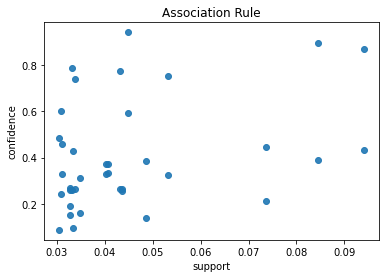

In [35]:

import matplotlib.pyplot as plt
plt.scatter(MarketBasket['support'], MarketBasket['confidence'], alpha=0.9)
plt.xlabel('support')
plt.ylabel('confidence')
plt.title("Association Rule")
plt.show()

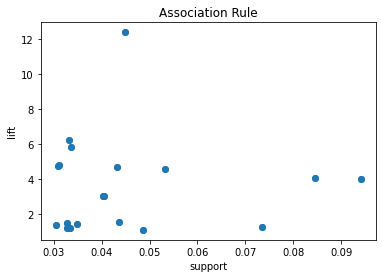

In [36]:
import matplotlib.pyplot as plt
plt.scatter(MarketBasket['support'], MarketBasket['lift'], alpha=0.9)
plt.xlabel('support')
plt.ylabel('lift')
plt.title("Association Rule")
plt.show()

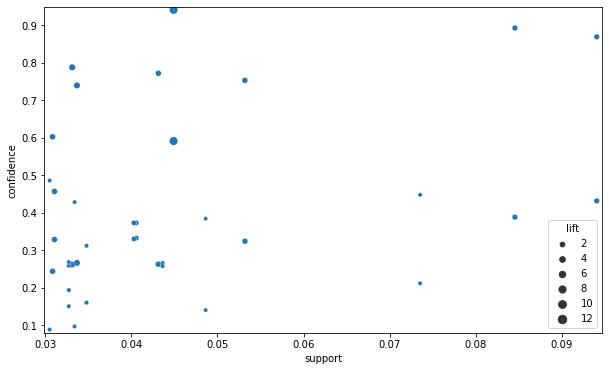

In [37]:
#support=MarketBasket.as_matrix(columns=['support'])
#confidence=MarketBasket.as_matrix(columns=['confidence'])
 
import seaborn as sns
import networkx as nx

plt.figure(figsize=(10,6))
sns.scatterplot(x = 'support',y = 'confidence',size = 'lift',data = MarketBasket)
plt.margins(0.01,0.01)
plt.show()

In [38]:
import seaborn as sns
# Convert antecedents and consequents into strings
MarketBasket['antecedents_'] = MarketBasket['antecedents'].apply(lambda a: ','.join(list(a)))
MarketBasket['consequents_'] = MarketBasket['consequents'].apply(lambda a: ','.join(list(a)))

print(MarketBasket[['antecedents'
,
'consequents']])


              antecedents            consequents
0       Touring Tire Tube           Touring Tire
1            Touring Tire      Touring Tire Tube
2          Road Tire Tube           HL Road Tire
3            HL Road Tire         Road Tire Tube
4            ML Road Tire         Road Tire Tube
5          Road Tire Tube           ML Road Tire
6                Road-750       Road Bottle Cage
7        Road Bottle Cage               Road-750
8            LL Road Tire         Road Tire Tube
9          Road Tire Tube           LL Road Tire
10     Mountain Tire Tube       ML Mountain Tire
11       ML Mountain Tire     Mountain Tire Tube
12       HL Mountain Tire     Mountain Tire Tube
13     Mountain Tire Tube       HL Mountain Tire
14       Road Bottle Cage           Water Bottle
15           Water Bottle       Road Bottle Cage
16           Water Bottle   Mountain Bottle Cage
17   Mountain Bottle Cage           Water Bottle
18           Mountain-200  Fender Set - Mountain
19  Fender Set - Mou

<AxesSubplot:xlabel='antecedents', ylabel='consequents'>

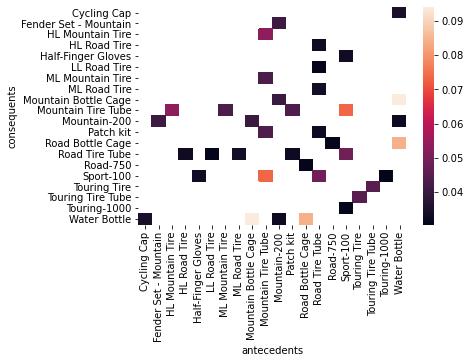

In [39]:
# Transform antecedent, consequent, and support columns into matrix
Association_table = MarketBasket.pivot(index='consequents',columns='antecedents',values='support')
# Generate heatmap
sns.heatmap(Association_table)

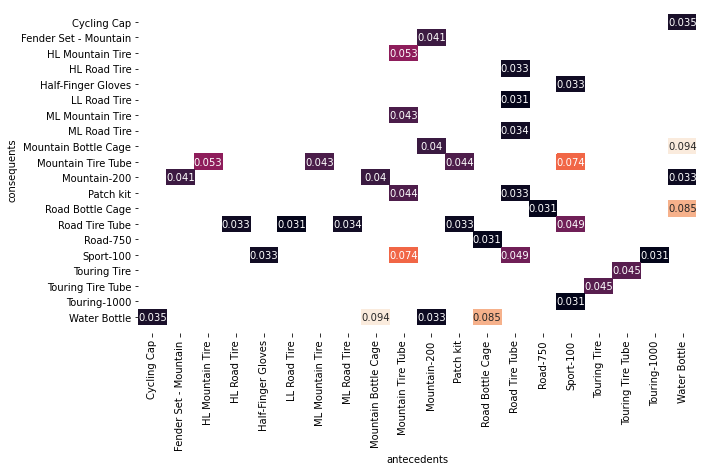

In [40]:

# Transform antecedent, consequent, and support columns into matrix
Association_table = MarketBasket.pivot(index='consequents',columns='antecedents',values='support')

plt.figure(figsize=(10,6))
sns.heatmap(Association_table, annot=True, cbar=False)
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t) 
plt.yticks(rotation=0)
plt.show() 

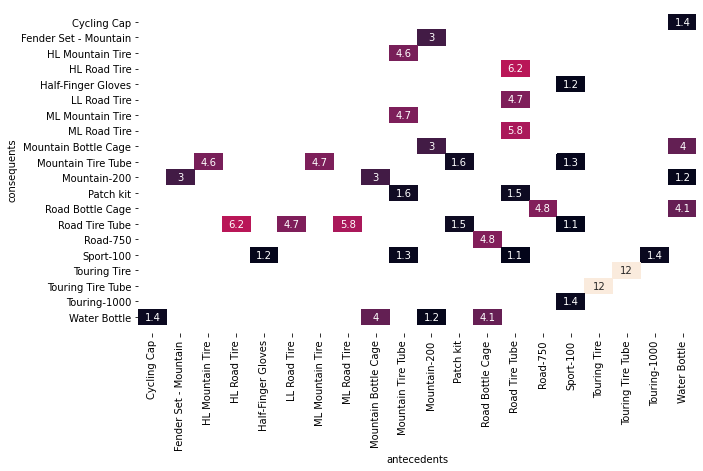

In [41]:
# Transform antecedent, consequent, and lift columns into matrix
pivot = MarketBasket.pivot(index='consequents',columns='antecedents',values='lift')
# Generate a heatmap with annotations on and the colorbar off
plt.figure(figsize=(10,6))
sns.heatmap(pivot, annot = True, cbar = False)
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t) 
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()



<AxesSubplot:xlabel='antecedents', ylabel='consequents'>

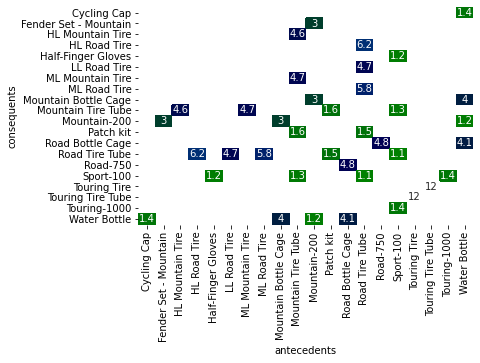

In [42]:
# customizing heatmaps
sns.heatmap(pivot, annot=True, cbar=False, cmap='ocean')

<AxesSubplot:xlabel='antecedent support', ylabel='consequent support'>

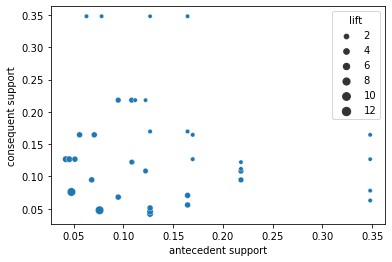

In [43]:
# generating a scatter plot with lift
sns.scatterplot(x="antecedent support",y="consequent support",size="lift",data=MarketBasket)

In [45]:
MarketBasket[1:10]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,Items_x,...,Revenue_WithMBA,Volume_WithMBA,Total_Revenue_WithoutMBA,TotalRevenue_Item_y,Basket_Revenue,Basket_Cost,TotalBasket_Profit,Profit_WithoutMBA,antecedents_,consequents_
1,Touring Tire,Touring Tire Tube,0.047746,0.076038,0.044911,0.940629,12.370504,0.041281,15.562418,Touring Tire,...,33.98,172,1913.34,309.786755,2223.126755,12.7086,2210.418155,1902.4977,"T,o,u,r,i,n,g, ,T,i,r,e","T,o,u,r,i,n,g, ,T,i,r,e, ,T,u,b,e"
2,Road Tire Tube,HL Road Tire,0.126786,0.042077,0.033128,0.261289,6.209840,0.027793,1.296750,Road Tire Tube,...,36.59,230,674.31,1439.545617,2113.855617,13.6847,2100.170917,672.8177,"R,o,a,d, ,T,i,r,e, ,T,u,b,e","H,L, ,R,o,a,d, ,T,i,r,e"
3,HL Road Tire,Road Tire Tube,0.042077,0.126786,0.033128,0.787318,6.209840,0.027793,4.105735,HL Road Tire,...,36.59,230,1988.60,191.625328,2180.225328,13.6847,2166.540628,1976.4076,"H,L, ,R,o,a,d, ,T,i,r,e","R,o,a,d, ,T,i,r,e, ,T,u,b,e"
4,ML Road Tire,Road Tire Tube,0.045578,0.126786,0.033684,0.739024,5.828929,0.027905,3.345962,ML Road Tire,...,28.98,235,1649.34,194.614580,1843.954580,10.8386,1833.115980,1639.9937,"M,L, ,R,o,a,d, ,T,i,r,e","R,o,a,d, ,T,i,r,e, ,T,u,b,e"
5,Road Tire Tube,ML Road Tire,0.126786,0.045578,0.033684,0.265673,5.828929,0.027905,1.299723,Road Tire Tube,...,28.98,235,674.31,1122.019438,1796.329438,10.8386,1785.490838,672.8177,"R,o,a,d, ,T,i,r,e, ,T,u,b,e","M,L, ,R,o,a,d, ,T,i,r,e"
6,Road-750,Road Bottle Cage,0.068090,0.094770,0.031071,0.456327,4.815115,0.024618,1.665026,Road-750,...,548.98,233,59938.89,455.364150,60394.254150,347.0119,60047.242250,59595.2404,"R,o,a,d,-,7,5,0","R,o,a,d, ,B,o,t,t,l,e, ,C,a,g,e"
7,Road Bottle Cage,Road-750,0.094770,0.068090,0.031071,0.327859,4.815115,0.024618,1.386481,Road Bottle Cage,...,548.98,233,1096.78,21598.950932,22695.730932,347.0119,22348.719032,1093.4177,"R,o,a,d, ,B,o,t,t,l,e, ,C,a,g,e","R,o,a,d,-,7,5,0"
8,LL Road Tire,Road Tire Tube,0.051248,0.126786,0.030849,0.601952,4.747796,0.024351,2.193743,LL Road Tire,...,25.48,243,1590.26,177.732348,1767.992348,9.5296,1758.462748,1582.2227,"L,L, ,R,o,a,d, ,T,i,r,e","R,o,a,d, ,T,i,r,e, ,T,u,b,e"
9,Road Tire Tube,LL Road Tire,0.126786,0.051248,0.030849,0.243314,4.747796,0.024351,1.253826,Road Tire Tube,...,25.48,243,674.31,883.670218,1557.980218,9.5296,1548.450618,672.8177,"R,o,a,d, ,T,i,r,e, ,T,u,b,e","L,L, ,R,o,a,d, ,T,i,r,e"
